<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [13]:
# if local
# !conda activate cs685

In [14]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [17]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [18]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/.shortcut-targets-by-id/1S8UITZ4wcfheudaDPm55HK4b4g-PPNuD/685-NLP-Project/implicit-hate-detection


In [19]:
# !git status

install requirements from repo 

In [20]:
# for colab, use venv if in local
!pip install -r requirements.txt

     |████████████████████████████████| 4.0 MB 28.7 MB/s 
     |████████████████████████████████| 1.8 MB 63.5 MB/s 
     |████████████████████████████████| 880 kB 58.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 46.4 MB/s 
     |████████████████████████████████| 181 kB 75.0 MB/s 
     |████████████████████████████████| 145 kB 74.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c15f225fca48935e99ecb66196e04e8d32596761bf8ce6277ef80ed4d4772944
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0af6d4408a403540420318aa70bbc44f2d57c1213f29935e1094532b41e1b129
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83e

load the helper and dataloader files

In [21]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [22]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [23]:
import os

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [24]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [25]:
# Stage 1 Annotations: see config.py for dataset specs
implicit_hate_dataset = Stage1Dataset(dataset_filename["stage-1"], drop_explicit_hate=True)

dataset_size = len(implicit_hate_dataset)
dataset_splits = [int(0.6*dataset_size), int(0.2*dataset_size), dataset_size - int(0.6*dataset_size) - int(0.2*dataset_size)]

# # Smaller dataset for testing model
# dataset_splits = [int(0.006*dataset_size), int(0.002*dataset_size), int(0.002*dataset_size)]
print("Dataset size", dataset_size)
print("Dataset splits", dataset_splits)

train_set, val_set, test_set = torch.utils.data.random_split(implicit_hate_dataset, dataset_splits)

train_dataloader =  DataLoader(train_set, batch_size=8, shuffle=False)
validation_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

# assert len(train_set) == int(0.6*dataset_size)
# assert len(val_set) == int(0.2*dataset_size)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Dataset size 20391
Dataset splits [12234, 4078, 4079]


In [26]:
# Confirming type is tensor
_, _, input_ids, attention_masks, labels = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [32]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_set, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    validation_dataloader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=True)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[2]
      input_mask_tensors = batch[3]
      label_tensors = batch[4]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        print("outputs", outputs)
        print("logits", logits)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        print("pred_flat", pred_flat.shape, pred_flat)
        print("labels_flat", labels_flat.shape, labels_flat)
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    final_score = precision_recall_fscore_support(predicted, labels)
    class_names=['not_hate', 'hate']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [28]:
!wandb login 

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [29]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "original-ppr-hparams-sweep",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [2e-5, 3e-5, 5e-5]
        },
        "epochs" : {
            "values" : [1, 2, 3, 4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: pukyorj0
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/pukyorj0


In [30]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader =  DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[2]
                input_mask_tensors = batch[3]
                label_tensors = batch[4]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                
                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_set, config, epoch_i, "val")
            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(model, test_set, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: qimhfmyz with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Streaming output truncated to the last 5000 lines.
outputs SequenceClassifierOutput(loss=tensor(0.3537, device='cuda:0'), logits=tensor([[ 1.2948, -1.1316],
        [ 1.0674, -0.9826],
        [ 1.2220, -0.9862],
        [-2.3176,  1.7563],
        [ 1.2435, -1.1898],
        [ 1.1630, -0.8933],
        [-2.4420,  2.0026],
        [ 1.3189, -1.1931]], device='cuda:0'), hidden_states=None, attentions=None)
logits tensor([[ 1.2948, -1.1316],
        [ 1.0674, -0.9826],
        [ 1.2220, -0.9862],
        [-2.3176,  1.7563],
        [ 1.2435, -1.1898],
        [ 1.1630, -0.8933],
        [-2.4420,  2.0026],
        [ 1.3189, -1.1931]], device='cuda:0')
pred_flat (8,) [0 0 0 1 0 0 1 0]
labels_flat (8,) [0 0 1 1 0 0 1 0]
outputs SequenceClassifierOutput(loss=tensor(0.0979, device='cuda:0'), logits=tensor([[ 1.5738, -1.4883],
        [ 1.7499, -1.5244],
        [ 1.9768, -1.6554],
        [ 1.5952, -1.3774],
        [ 0.5361, -0.4743],
        [ 1.4230, -1.4273],
        [-2.3674,  1.9059],


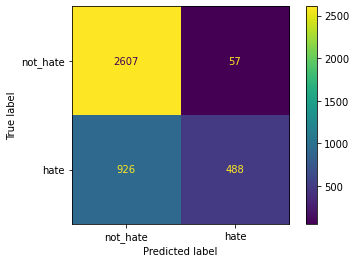

Streaming output truncated to the last 5000 lines.
        [ 0.5156, -0.4467],
        [ 1.2400, -0.9702],
        [ 0.8438, -0.6780],
        [ 0.7916, -0.8344],
        [ 0.8380, -0.6620],
        [ 1.3182, -1.1386]], device='cuda:0'), hidden_states=None, attentions=None)
logits tensor([[-0.3223,  0.2860],
        [ 1.4333, -1.3169],
        [ 0.5156, -0.4467],
        [ 1.2400, -0.9702],
        [ 0.8438, -0.6780],
        [ 0.7916, -0.8344],
        [ 0.8380, -0.6620],
        [ 1.3182, -1.1386]], device='cuda:0')
pred_flat (8,) [1 0 0 0 0 0 0 0]
labels_flat (8,) [1 0 1 0 0 1 0 0]
outputs SequenceClassifierOutput(loss=tensor(0.2673, device='cuda:0'), logits=tensor([[ 1.7014, -1.4908],
        [ 0.7831, -0.6883],
        [ 0.7931, -0.7756],
        [ 0.9650, -0.8736],
        [ 1.6380, -1.3643],
        [ 1.1139, -1.0883],
        [ 0.0180, -0.1370],
        [-0.1276,  0.0081]], device='cuda:0'), hidden_states=None, attentions=None)
logits tensor([[ 1.7014, -1.4908],
        [ 0.783

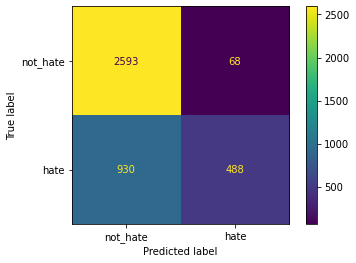

[0.9744457  0.34414669] [0.73602044 0.87769784] [0.83861578 0.49442756]
[0.9744457  0.34414669] [0.73602044 0.87769784] [0.83861578 0.49442756]
Test accuracy: 0.755332189262074


batch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▆▅▄▇▂▄▄▆▅▃▆▂█▅▅▅▆▅▂▇▆▂▁▃▁▆▄▅▅▃▄▅▂▆▃▄█▄▄▁
epoch,▁
loss,▁
test_acc,▁
val_acc,▁
batch,1529
batch_loss,0.1673
epoch,1
loss,791.23526
test_acc,0.75533


In [33]:
count = 1 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")